<center><h1>Final Notebook</h1></center>

This is the notebook containing the runtime implementation of the TableNet Case Study. This notebook will contain a Final() function that will take as input the path to the imput image and will generate the table and column masks which will be then used to filter the table from the image and finally text will be extracted from the table using OCR.

__Video showcasing deployment on Streamlit:__ https://youtu.be/mHdxzDvSxPQ

In [ ]:
# installing pytesseract for OCR
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,866 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Personal\ Case\ Study\ 2

/content/drive/MyDrive/Personal Case Study 2


In [ ]:
!pwd

/content/drive/MyDrive/Personal Case Study 2


### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from PIL import Image
import pytesseract
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Concatenate, Add, Activation, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet121

### Making the model architecture and loading the saved weights.

In [ ]:
class table_decoder(tf.keras.layers.Layer):
    '''
        This is the custom layer defined for the table decoder following the above architecture.
    '''
    def __init__(self):
        super().__init__()
        # defining the layers
        self.conv7 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001))
        self.upsamp_pool4 = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsamp_pool3 = UpSampling2D(size=(2,2), interpolation='bilinear')
        self.upsamp_out = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=2, padding='same', activation='softmax')
        
    def call(self, inp, pool3, pool4):
        # passing through convolution
        x = self.conv7(inp)
        # upsampling and concatenating with pool4
        x = self.upsamp_pool4(x)
        x = Concatenate()([x, pool4])
        
        # upsampling and concatenating with pool3
        x = self.upsamp_pool3(x)
        x = Concatenate()([x, pool3])
        
        # further upsampling and output
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        fin = self.upsamp_out(x)
        
        return fin

In [ ]:
class col_decoder(tf.keras.layers.Layer):
    '''
        This custom layer is defined for the Column deocder following the above column decoder architecture. 
    '''
    def __init__(self):
        super().__init__()
        # defining the layers
        self.conv7 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001), activation='relu')
        self.drop = Dropout(rate=0.8)
        self.conv8 = Conv2D(filters=128, kernel_size=(1,1), kernel_regularizer=regularizers.l2(0.001))
        self.upsamp_pool4 = UpSampling2D((2,2), interpolation='bilinear')
        self.upsamp_pool3 = UpSampling2D((2,2), interpolation='bilinear')
        self.upsamp_out = Conv2DTranspose(filters=2, kernel_size=(3,3), strides=2, padding='same', activation='softmax')
        
    def call(self, inp, pool3, pool4):
        # passing through convolutions
        x = self.conv7(inp)
        x = self.drop(x)
        x = self.conv8(x)
        
        # upsampling and concatenating encoder pool outputs
        x = self.upsamp_pool4(x)
        x = Concatenate()([x, pool4])
        x = self.upsamp_pool3(x)
        x = Concatenate()([x, pool3])
        
        # final upsampling and outputs
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)
        fin = self.upsamp_out(x)
        
        return fin

In [ ]:
# making the encoder architecture
tf.keras.backend.clear_session()
model_input = Input(shape=(1024,1024,3))
encoder = DenseNet121(include_top=False, weights='imagenet', input_tensor=model_input)

# for pool3 and pool4, we are going to use the outputs of the following layers
# pool4 = pool4_relu
# pool3 = pool3_relu
pool3 = encoder.get_layer('pool3_relu').output
pool4 = encoder.get_layer('pool4_relu').output

# making all the layers of the encoder untrainable
for layer in encoder.layers:
    layer.trainable = False

# continuing the model architecture
# convolution layers
conv_6 = Conv2D(filters=512, kernel_size=(1,1), activation='relu', name='block6_conv1',
                kernel_regularizer=regularizers.l2(0.001))(encoder.output)
conv6_drop = Dropout(0.2)(conv_6) # this is the dropping probability and in the paper the keep_prop seems to be 0.8.

conv_7 = Conv2D(filters=256, kernel_size=(1,1), activation='relu', name='block6_conv2',
                kernel_regularizer=regularizers.l2(0.001))(conv6_drop)
conv7_drop = Dropout(0.2)(conv_7) # this is the dropping probability and in the paper the keep_prop seems to be 0.8.

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
# decoders
table_mask = table_decoder()
column_mask = col_decoder()

table_out = table_mask(conv7_drop, pool3, pool4)
column_out = column_mask(conv7_drop, pool3, pool4)

# declaring the model
tablenet = Model(inputs=model_input, outputs=[table_out, column_out])
tablenet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 1030, 1030, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 512, 512, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# loading the weights
tablenet.load_weights('DenseNet-Tablenet.h5')

### Making the final function
#### Some helper functions

In [ ]:
def load_image(path):
    '''
        This function reads the image using and performs preprocessing on it.
    '''
    image = tf.io.read_file(path)
    image = tf.io.decode_bmp(image, channels=4)[:,:,:3]
    image = tf.image.resize(image, size=[1024,1024])
    image = tf.cast(image, dtype=tf.float32)/255
    return image

In [ ]:
def get_mask_image(mask_pred):
    '''
        This function gets the predicted mask image from the masks predicted by the model
    '''
    # taking argmax from both the channels
    mask_pred = tf.argmax(mask_pred, axis=-1)
    # adding a channel axis
    mask_pred = mask_pred[..., tf.newaxis][0]
    
    return mask_pred

In [ ]:
def filter_table(image, table_mask):
    '''
        This function turns the image from a matrix to actual image and then uses the table mask to filter out the table from the image.
    '''
    # converting image and mask from matrices to images
    im = tf.keras.preprocessing.image.array_to_img(image)
    mask = tf.keras.preprocessing.image.array_to_img(table_mask)

    # converting mask to greyscale
    mask = mask.convert('L')

    # changing the alpha values of the image using the table mask
    im.putalpha(mask)
    
    return im

In [ ]:
# loading the dataframe for paths
data_paths = pd.read_csv('Marmot_data/dataset_final_colab.csv')
data_paths.head(1)

,Image,xml,Column_mask,Table_mask
0,Marmot_data/Images/10.1.1.1.2006_3.bmp,Marmot_data/xmls/10.1.1.1.2006_3.xml,Marmot_data/Column_masks/10.1.1.1.2006_3.jpeg,Marmot_data/Table_masks/10.1.1.1.2006_3.jpeg


#### Final()

In [ ]:
def final(path):
    '''
        This function resembles the implemetation of the end-to-end tablenet model.
        It starts with reading the image from the path, making predictions on that image, using the table prediction to then filter the table out of the image and then
        extract text from the image using OCR.
    '''
    # reading the image
    image = load_image(path)
    # adding a batch dimension to the image
    image = tf.reshape(image, shape=(1,1024,1024,3))
    # making predictions and getting masks
    table_mask_pred, col_mask_pred = tablenet.predict(image)
    # getting the argmax of the predicted masks and adding a channel dimension
    table_mask_pred = get_mask_image(table_mask_pred)
    col_mask_pred = get_mask_image(col_mask_pred)

    # filtering the table out using the table mask
    table = filter_table(image[0], table_mask_pred)

    # plotting the images
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    ax[0].imshow(image[0])
    ax[0].set_title('Original Image')
    ax[1].imshow(table_mask_pred[:,:,0])
    ax[1].set_title('Predicted Table Mask')
    ax[2].imshow(col_mask_pred[:,:,0])
    ax[2].set_title('Predicted Column Mask')
    ax[3].imshow(table)
    ax[3].set_title('Filtered Table')
    # turning axis off for each axis
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    plt.show()

    # now, we use pytesseract to extract text from the image
    # refer: https://towardsdatascience.com/how-to-extract-text-from-images-using-tesseract-ocr-engine-and-python-22934125fdd5
    text_data = pytesseract.image_to_string(table, lang='eng')
    print("Extracted Text using OCR:")
    print(text_data)

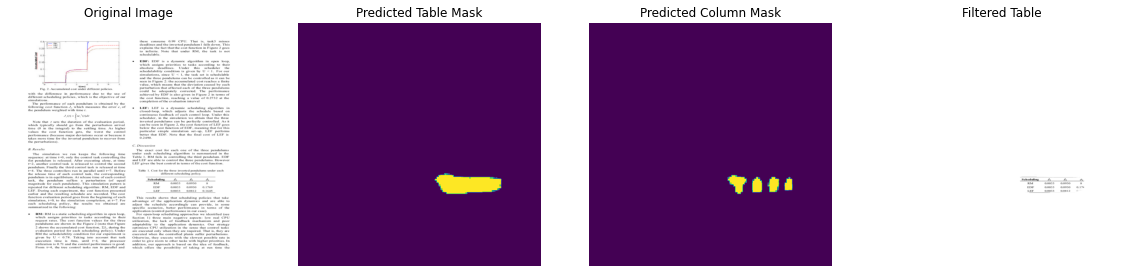

Extracted Text using OCR:
Scheduling J, te ts
RM 0.0033 0.0930 s
EDF 0.0033 0.0930 0.176

0.0033 00812 =

 



In [ ]:
# testing for one image
path = data_paths['Image'][0]
final(path)

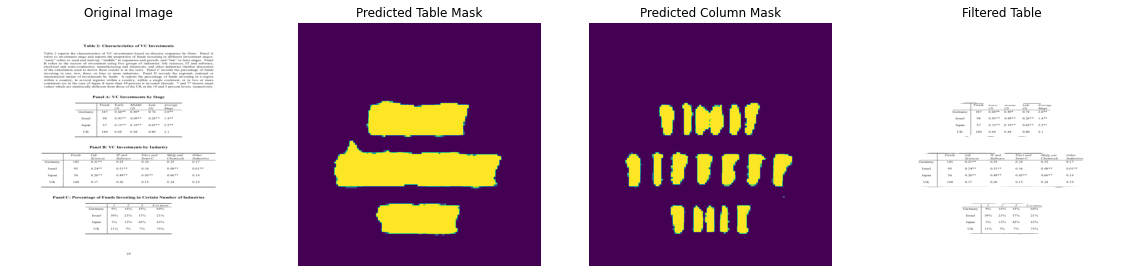

Extracted Text using OCR:
   

Average

Germany

 

 

 

Finds Life Ti and Electand Mnf ane Other
Sciences Sofware Semi-C. Chemicals Industries
Germany TSS 0.21 0.23 0.16 0.23 O17
Israel os 0.24" ost 0.16 0.08**
Japan 36 0.26** 0.49%* 0.05** 0.06**
UK 140 0.17 0.26 oas 0.24 0.19

 

    

dor more

  

 



In [ ]:
# testing for another image
path = data_paths['Image'][10]
final(path)